# Augmentation d'image - Control 1/2
## Objectif
Ce notebook sert de référence afin de comparer les différentes facon de d'augmenter les donner une à une. Pour commencer, ce notebook hormis le horizontal_flip n'aura pas d'augemntation de données

## Hypthoses générales

- Il est possible que certaines transformations soient plus efficaces lorsqu'elles sont combinées. Par exemple, appliquer un zoom et une rotation peut être plus efficace que simplement appliquer un zoom ou une rotation séparément. Tester chaque paramètre un par un ne capture pas nécessairement ces effets combinés.
- Overfitting sera important tant que les données ne seront pas augmentées en multipliant et combinant le nombre de techniques d'augmentation.

## Hypothèses spécifiques au notebook
- La diversité des données ne va pas être suffisante et le model va certainement fixer sur les signes distinctifs (lettres) sans la spécificité des poumons sains ou malades.

## Etapes de la démarche
1. Créer un notebook contrôle depuis le template v2 sans aucun paramètre associé à l'ImageDataGenerator de Keras
2. Créer autant de notebook que de paramètres à tester
3. Créer un notebook avec l'ensemble des paramètres activés
4. Comparer les résultats avec les résultats du template

## Interprétation des résultats et Conclusion
Les résultats obtenus sont les suivants :
- Les performances ont chuté à 70 auc
- La similarité des données d'entrainement n'a pas permis au model de suffisament généralisé et lorsqu'il est soumis aux données de validation les métriques indiquent un model faisant beaucoup de faux positif
- La heatmap semble indiquer que le modèle fixe sur base une partie de sa catégorisation sur la presence des lettres

In [1]:
# Check that GPU is used
import tensorflow as tf

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:

# Chargez les variables d'environnement

TRAIN_FOLDER = 'train'
TEST_FOLDER = 'test'
VAL_FOLDER = 'val'

TRAIN_AUGMENTED_FOLDER = 'train_augmented'
ITERATION = 'v1'
# Define the subfolders within each folder where the images are stored
subfolders = ['NORMAL', 'PNEUMONIA']

# Define the size of the images you want to resize your images to
img_width, img_height = 128, 128  # Function to load and resize images from a folder

In [3]:
# Fonction de chargement des images des dataset et des labels associés
def load_images_from_folder(folder, limit_per_subfolder=None):
    X = []
    y = []
    for subfolder in subfolders:
        folder_path = os.path.join(folder, subfolder)
        if limit_per_subfolder:
            # Get amount of random filenames from the folder
            filenames = np.random.choice(os.listdir(folder_path), limit_per_subfolder, replace=False)
        else:
            filenames = os.listdir(folder_path)
        for filename in filenames:
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path)

            # Resize the image to the desired size
            img = img.resize((img_width, img_height))

            # Convert RGB image to grayscale
            img = img.convert('L')

            # Convert the image to a NumPy array and append it to X
            img = np.array(img)
            X.append(img)

            # Append the corresponding label to y
            y.append(subfolders.index(subfolder))

    X = np.array(X)
    y = np.array(y)
    return X, y

In [4]:
import os
import numpy as np
from PIL import Image, ImageOps
from keras.preprocessing.image import ImageDataGenerator

def generate_augmented_images(folder, to_augment_class, image_size=(128, 128), target_nbr=5000):
    dir = os.path.join(folder, to_augment_class)
    count = len(os.listdir(dir))

    augmented_dir = os.path.join(f"{folder}_augmented_{ITERATION}", to_augment_class)

    if not os.path.exists(f"{folder}_augmented{ITERATION}"):
        os.mkdir(f"{folder}_augmented{ITERATION}")

    if not os.path.exists(augmented_dir):
        os.mkdir(augmented_dir)

    augmented_count = len(os.listdir(augmented_dir))

    datagen = ImageDataGenerator(
            rotation_range=0,
            width_shift_range=0,
            height_shift_range=0,
            shear_range=0,
            zoom_range=0,
            horizontal_flip=True,
            fill_mode='nearest'
    )

    generator = datagen.flow_from_directory(

        folder,
        batch_size=1,
        save_to_dir=augmented_dir,
        save_format='jpeg',
        save_prefix='IM_AUGMENTED',
        classes=[to_augment_class],
        # keep_aspect_ratio=True,
        # target_size=image_size,
    )

    additional_count = target_nbr - len(os.listdir(augmented_dir))

    for i in range(additional_count):
        generator.next()

    new_count = len(os.listdir(augmented_dir))

    print(f'Given {to_augment_class} count: {count}')
    print(f'Augmented {to_augment_class} count: {new_count}')

In [5]:

generate_augmented_images(TRAIN_FOLDER, 'NORMAL', image_size=(img_width, img_height))
generate_augmented_images(TRAIN_FOLDER, 'PNEUMONIA', image_size=(img_width, img_height))


Found 1341 images belonging to 1 classes.
Given NORMAL count: 1341
Augmented NORMAL count: 5000
Found 3875 images belonging to 1 classes.
Given PNEUMONIA count: 3876
Augmented PNEUMONIA count: 5000


In [6]:
# Load the training data
# Get min value between the number of normal images and the number of pneumonia images
TRAIN_FOLDER = f"{TRAIN_AUGMENTED_FOLDER}_{ITERATION}"

TEST_FOLDER = f"{TEST_FOLDER}"
VAL_FOLDER = f"{VAL_FOLDER}"

min_images = min(len(os.listdir(os.path.join(TRAIN_FOLDER, subfolders[0]))),
                 len(os.listdir(os.path.join(TRAIN_FOLDER, subfolders[1]))))
X_train, y_train = load_images_from_folder(TRAIN_FOLDER, min_images)

# Load the test data
X_test, y_test = load_images_from_folder(TEST_FOLDER)

# Load the validation data
X_val, y_val = load_images_from_folder(VAL_FOLDER)

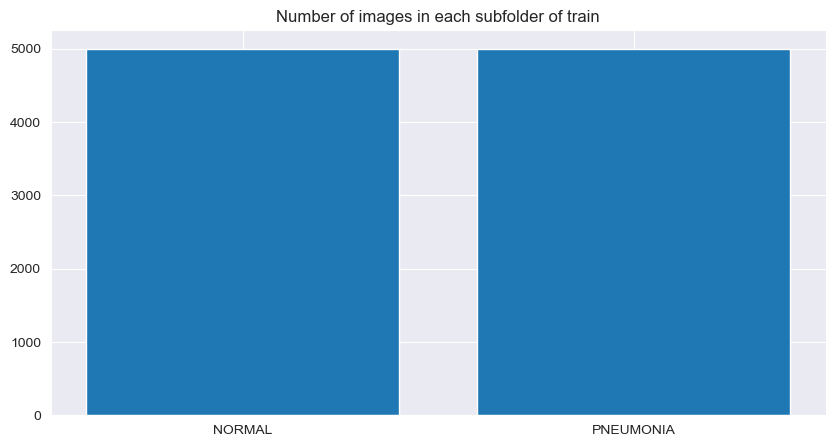

In [7]:
# Make a matplot figure to show how many images are in each subfolder of train
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(subfolders, [len(os.listdir(os.path.join(TRAIN_FOLDER, subfolder))) for subfolder in subfolders])
plt.title('Number of images in each subfolder of train')
plt.show()

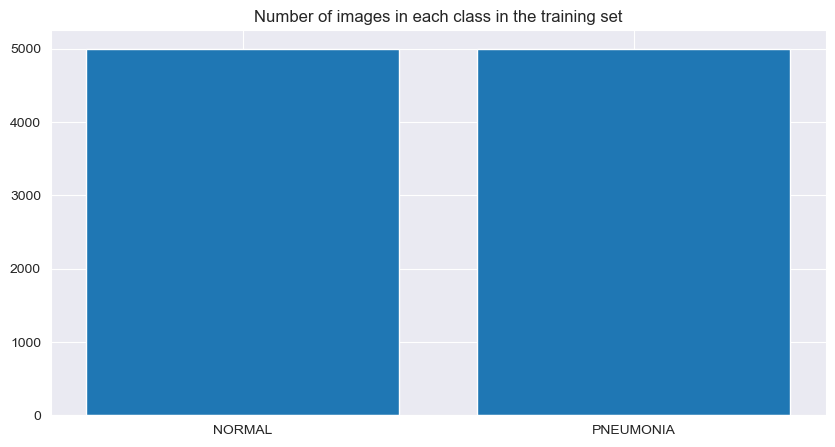

In [8]:
# Make a matplot figure to show how many images if each class in the training set
plt.figure(figsize=(10, 5))
plt.bar(subfolders, [len(y_train[y_train == i]) for i in range(len(subfolders))])
plt.title('Number of images in each class in the training set')
plt.show()

In [9]:
# Normalize the pixel values to be between 0 and 1
num_samples = X_train.shape[0]
print(X_test.shape)
X_train = X_train.reshape(len(X_train), img_width, img_height, 1)
X_test = X_test.reshape(len(X_test), img_width, img_height, 1)
X_val = X_val.reshape(len(X_val), img_width, img_height, 1)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_val = X_val.astype('float32') / 255

print('done \n')

(624, 128, 128)
done 



(128, 128, 1)


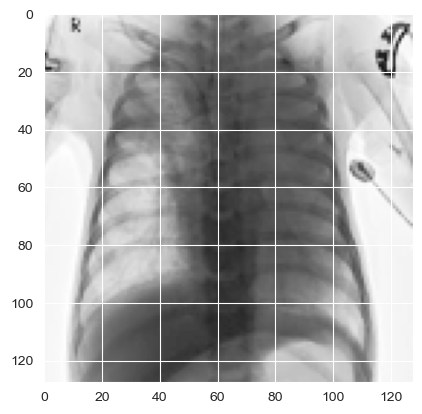

In [10]:
single_image = X_train[np.random.randint(len(X_train))]
print(single_image.shape)
plt.imshow(single_image, cmap='Greys')

In [11]:
# Define model metrics
from keras.metrics import AUC

metrics = [
    "accuracy",
    AUC(name='auc')
]

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


# Define the model architecture
def create_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(img_width, img_height, 1), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))

    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation="sigmoid"))

    # compile the model
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=metrics)

    return model

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

In [14]:
# Cross validation
from sklearn.model_selection import KFold
from keras.preprocessing.image import ImageDataGenerator
from h5py import File
# Define the number of folds for cross-validation
n_splits = 10
epochs = 7
batch_size =64

# Initialize KFold with the number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define lists to store the evaluation scores for each fold
accuracy_scores = []
og_val_accuracy_scores = []
histories = []
models = []
fold_no = 1
best_score = float('inf')  # pour une tâche de minimisation
best_model = None
# Iterate through each fold and train/evaluate the model
for train_idx, val_idx in kf.split(X_train, y_train):
    # Split the data into training and validation sets for this fold
    X_train_fold, y_train_fold = X_train[train_idx], y_train[train_idx]
    X_val_fold, y_val_fold = X_train[val_idx], y_train[val_idx]

    # Create an instance of ImageDataGenerator to generate your image data
    datagen = ImageDataGenerator()

    # Create generators for training and validation data
    train_generator = datagen.flow(x=X_train_fold, y=y_train_fold, batch_size=batch_size)
    valid_generator = datagen.flow(x=X_val_fold, y=y_val_fold, batch_size=batch_size)

    # Create instance of the model for this fold and train it
    model = create_model()

    # Train your model on the training data for this fold
    history = model.fit(train_generator, validation_data=valid_generator, epochs=epochs, verbose=1,
                        callbacks=[early_stop])
    # Model Évaluation with original val dataset
    scores = model.evaluate(X_val, y_val, verbose=1)
    og_val_accuracy_scores.append(scores[1])
    print(f'\nScore for fold with orginal val dataset {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%\n')

    histories.append(history.history)

    models.append(model)

    # After training, evaluate the model on the validation set for this fold
    accuracy = model.evaluate(X_val_fold, y_val_fold)[1]

    # Store the accuracy score in the list
    accuracy_scores.append(accuracy)

    # Print the accuracy for this fold
    print(f"Accuracy for fold {len(accuracy_scores)}: {accuracy * 100}%")

    # Check if the model is better than the previous
    if scores[0] < best_score:
        best_score = scores[0]
        best_model = model

    fold_no = fold_no + 1

    # Sauvegarde du meilleur modèle
    if best_model is not None:
        best_model.save('cnn_best.h5')

# Calculate and print the average accuracy over all folds
average_accuracy = sum(accuracy_scores) / len(accuracy_scores)
og_val_average_accuracy = sum(og_val_accuracy_scores) / len(og_val_accuracy_scores)
print(f"\nAverage accuracy: {average_accuracy * 100}%")
print(f"\nAverage accuracy with orginal val: {og_val_average_accuracy * 100}%")

Epoch 1/7
141/141 [==============================] - 14s 67ms/step - loss: 0.4597 - accuracy: 0.7439 - auc: 0.8501 - val_loss: 0.1481 - val_accuracy: 0.9410 - val_auc: 0.9863
Epoch 2/7
141/141 [==============================] - 8s 59ms/step - loss: 0.1561 - accuracy: 0.9463 - auc: 0.9841 - val_loss: 0.1244 - val_accuracy: 0.9610 - val_auc: 0.9927
Epoch 3/7
141/141 [==============================] - 8s 59ms/step - loss: 0.0947 - accuracy: 0.9694 - auc: 0.9929 - val_loss: 0.0830 - val_accuracy: 0.9680 - val_auc: 0.9956
Epoch 4/7
141/141 [==============================] - 8s 59ms/step - loss: 0.0756 - accuracy: 0.9767 - auc: 0.9951 - val_loss: 0.0584 - val_accuracy: 0.9830 - val_auc: 0.9972
Epoch 5/7
141/141 [==============================] - 8s 59ms/step - loss: 0.0642 - accuracy: 0.9772 - auc: 0.9967 - val_loss: 0.0649 - val_accuracy: 0.9810 - val_auc: 0.9970
Epoch 6/7
141/141 [==============================] - 8s 59ms/step - loss: 0.0484 - accuracy: 0.9847 - auc: 0.9980 - val_loss: 0.0

In [15]:
# Get accuracy scores for each fold (train and validation)
loss = []
acc = []
val_loss = []
val_acc = []

for history in histories:
    loss.append(np.mean(history["loss"]))
    acc.append(np.mean(history["accuracy"]))
    val_loss.append(np.mean(history["val_loss"]))
    val_acc.append(np.mean(history["val_accuracy"]))

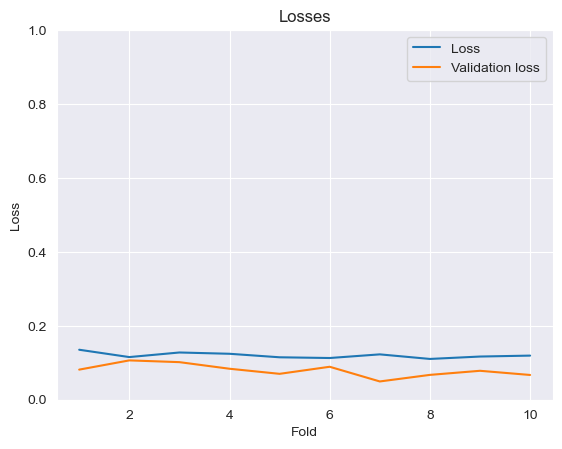

In [16]:
# Plot loss and validation loss per fold
import matplotlib.pyplot as plt
plt.title('Losses')
plt.plot(range(1, len(loss)+1), loss, label='Loss')
plt.plot(range(1, len(val_loss)+1), val_loss, label='Validation loss')
plt.ylim(0.0, 1.0)
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend()
plt.show()

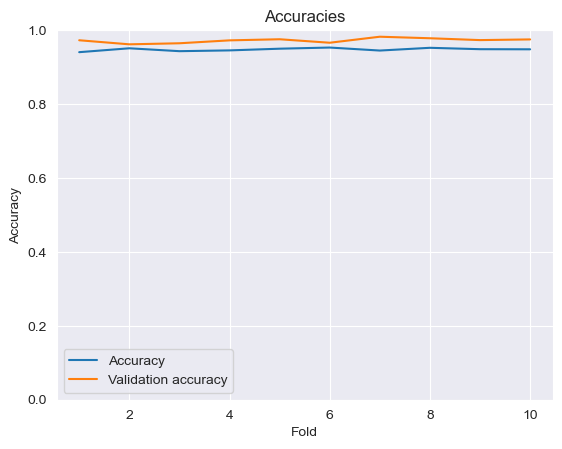

In [17]:
# Plot accuracies and validation accuracies per fold
import matplotlib.pyplot as plt

plt.title('Accuracies')
plt.plot(range(1, len(acc) + 1), acc, label='Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation accuracy')
plt.ylim(0.0, 1.0)
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
# Train a final model with same parameters and save it
# Create an instance of ImageDataGenerator to generate your image data
datagen = ImageDataGenerator()
train_generator = datagen.flow(x=X_train, y=y_train, batch_size=batch_size)
valid_generator = datagen.flow(x=X_val, y=y_val, batch_size=batch_size)
model = create_model()
history = model.fit(train_generator, validation_data=valid_generator, epochs=epochs, verbose=1, callbacks=[early_stop])
model.save('cnn.h5')

Epoch 1/7
157/157 [==============================] - 10s 60ms/step - loss: 0.3980 - accuracy: 0.8034 - auc: 0.9209 - val_loss: 0.3002 - val_accuracy: 0.8125 - val_auc: 0.9375
Epoch 2/7
157/157 [==============================] - 9s 57ms/step - loss: 0.1242 - accuracy: 0.9544 - auc: 0.9899 - val_loss: 0.2606 - val_accuracy: 0.8750 - val_auc: 0.9688
Epoch 3/7
157/157 [==============================] - 9s 57ms/step - loss: 0.0901 - accuracy: 0.9680 - auc: 0.9942 - val_loss: 0.3615 - val_accuracy: 0.8125 - val_auc: 1.0000
Epoch 4/7
157/157 [==============================] - 9s 57ms/step - loss: 0.0660 - accuracy: 0.9763 - auc: 0.9966 - val_loss: 0.1365 - val_accuracy: 0.9375 - val_auc: 1.0000
Epoch 5/7
157/157 [==============================] - 9s 57ms/step - loss: 0.0494 - accuracy: 0.9836 - auc: 0.9973 - val_loss: 0.2654 - val_accuracy: 0.8750 - val_auc: 1.0000
Epoch 6/7
157/157 [==============================] - 9s 57ms/step - loss: 0.0429 - accuracy: 0.9855 - auc: 0.9983 - val_loss: 0.2

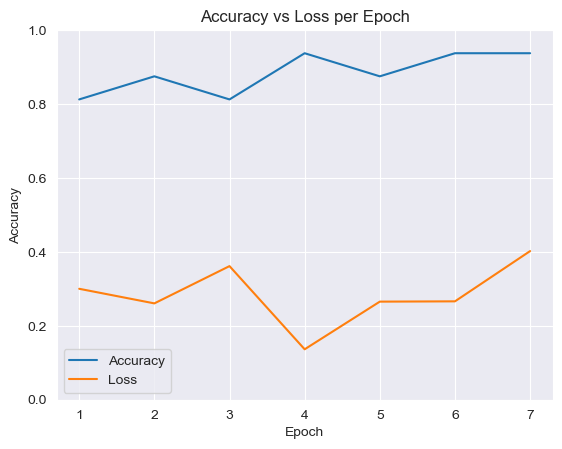

In [19]:
# Plot val accuracy and val loss of the trained model
import matplotlib.pyplot as plt

plt.title('Accuracy vs Loss per Epoch')
plt.plot(range(1, len(history.history["val_accuracy"]) + 1), history.history["val_accuracy"], label='Accuracy')
plt.plot(range(1, len(history.history["val_loss"]) + 1), history.history["val_loss"], label='Loss')
plt.ylim(0.0, 1.0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
 from tensorflow.keras.models import load_model
# Make predictions on the test set
model = load_model(f'cnn_{ITERATION}.h5')

In [21]:

# Make predictions on the test set

y_pred_test = model.predict(X_test)
y_pred_test = np.where(y_pred_test >= 0.5, 1, 0)

20/20 [==============================] - 0s 8ms/step


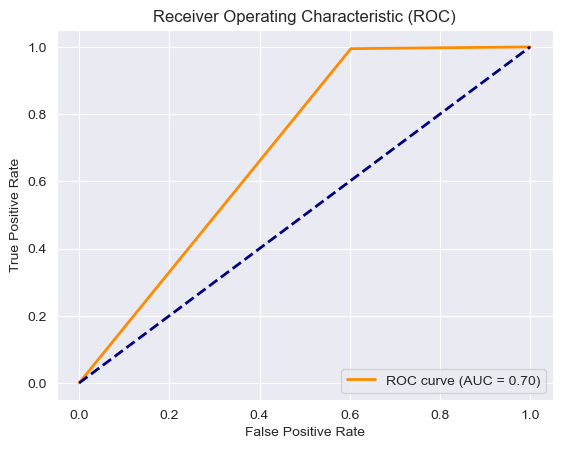

In [22]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and AUC score for the predictions
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)

# Plot ROC curve and show AUC score on the plot
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [23]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix for test set
cm = confusion_matrix(y_test, y_pred_test.flatten())
print(cm)

[[ 93 141]
 [  2 388]]


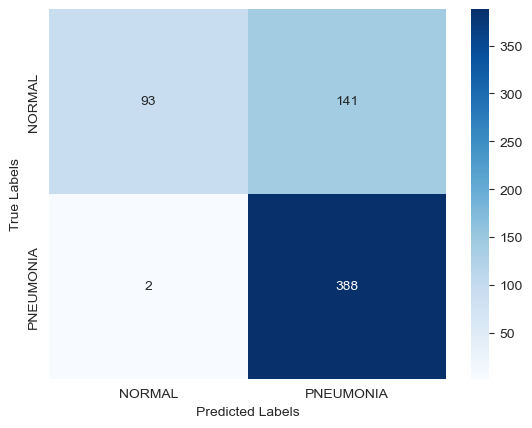

In [24]:
# Plot the confusion matrix
class_names = subfolders
import seaborn as sns

sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [25]:
# Compute the classification report for test set
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_test, target_names=class_names))

              precision    recall  f1-score   support

      NORMAL       0.98      0.40      0.57       234
   PNEUMONIA       0.73      0.99      0.84       390

    accuracy                           0.77       624
   macro avg       0.86      0.70      0.70       624
weighted avg       0.83      0.77      0.74       624



In [26]:
import tensorflow as tf
import numpy as np
from IPython.display import Image, display
import matplotlib.cm as cm
from keras.utils import load_img, img_to_array, array_to_img


def get_img_array(img_path, size):
    # `img` is a PIL image of size 256x256
    img = load_img(img_path, target_size=size, grayscale=True)
    # `array` is a float32 Numpy array of shape (256, 256, 3)
    array = img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    #grads = tf.expand_dims(grads, axis=0)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def generate_superimposed_gradcam(img_path, heatmap, alpha=0.4):
    # Load the original image
    img = load_img(img_path)
    img = img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = array_to_img(superimposed_img)

    return superimposed_img


def display_heatmaps(img_path, heatmaps, superimposed=False):
    import matplotlib.pyplot as plt

    # Define the number of columns for the subplot grid
    n_cols = min(len(heatmaps), 5)

    # Calculate the number of rows based on the number of columns and total number of images
    n_rows = (len(heatmaps) - 1) // n_cols + 1

    # Create a figure with the desired size
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))

    for i, heatmap in enumerate(heatmaps):
        # Calculate the row and column index for this heatmap
        row = i // n_cols
        col = i % n_cols

        # Get the corresponding subplot
        ax = axes[row, col] if n_rows > 1 else axes[col]

        # Set the title of the subplot to the layer name
        ax.set_title(heatmap['layer_name'])

        if superimposed:
            superimposed_img = generate_superimposed_gradcam(img_path, heatmaps[i]["image"])
            # Plot the heatmap
            ax.imshow(superimposed_img)
        else:
            # Plot the heatmap
            ax.imshow(heatmaps[i]["image"], cmap='jet')

    # Hide the remaining subplots that are not used
    for i in range(len(heatmaps), n_rows * n_cols):
        # Calculate the row and column index for this subplot
        row = i // n_cols
        col = i % n_cols

        # Get the corresponding subplot
        ax = axes[row, col] if n_rows > 1 else axes[col]

        # Hide the subplot
        ax.axis('off')

    # Adjust the spacing between subplots
    fig.tight_layout()

    # Show the plot
    plt.show()

In [27]:
# Remove last layer's softmax
model.layers[-1].activation = None

# import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [28]:
# Print model summary to get last max pooling layer name
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 14, 14, 128)    

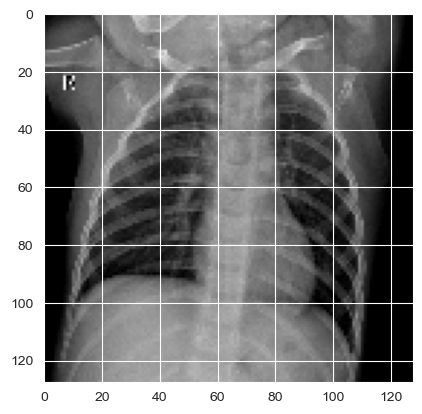

C:\ProgramData\anaconda3\envs\env\lib\site-packages\keras\utils\image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


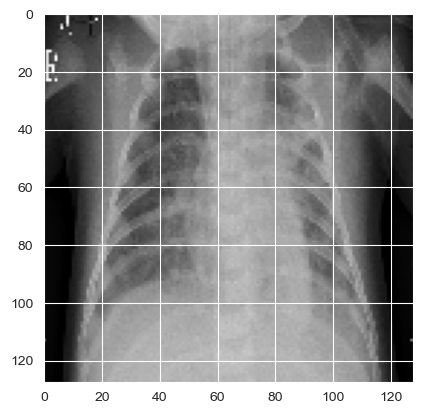

In [29]:
# Heatmaps and Grad-CAM

import cv2
import matplotlib.pyplot as plt

images = [
    {
        "path": "./val/NORMAL/NORMAL2-IM-1442-0001.jpeg"
    },
    {
        "path": "./val/PNEUMONIA/person1946_bacteria_4874.jpeg"
    }

]

for image in images:
    image_temp = cv2.imread(image["path"])
    image_temp = cv2.cvtColor(image_temp, cv2.COLOR_RGB2GRAY)
    image_temp = cv2.resize(image_temp, (img_width, img_height))

    plt.imshow(image_temp, cmap=plt.cm.gray)
    plt.show()

    image["array"] = get_img_array(image["path"], size=(img_width, img_height))


In [30]:
# Select last conv layer
last_conv_layer_name = "max_pooling2d_47"

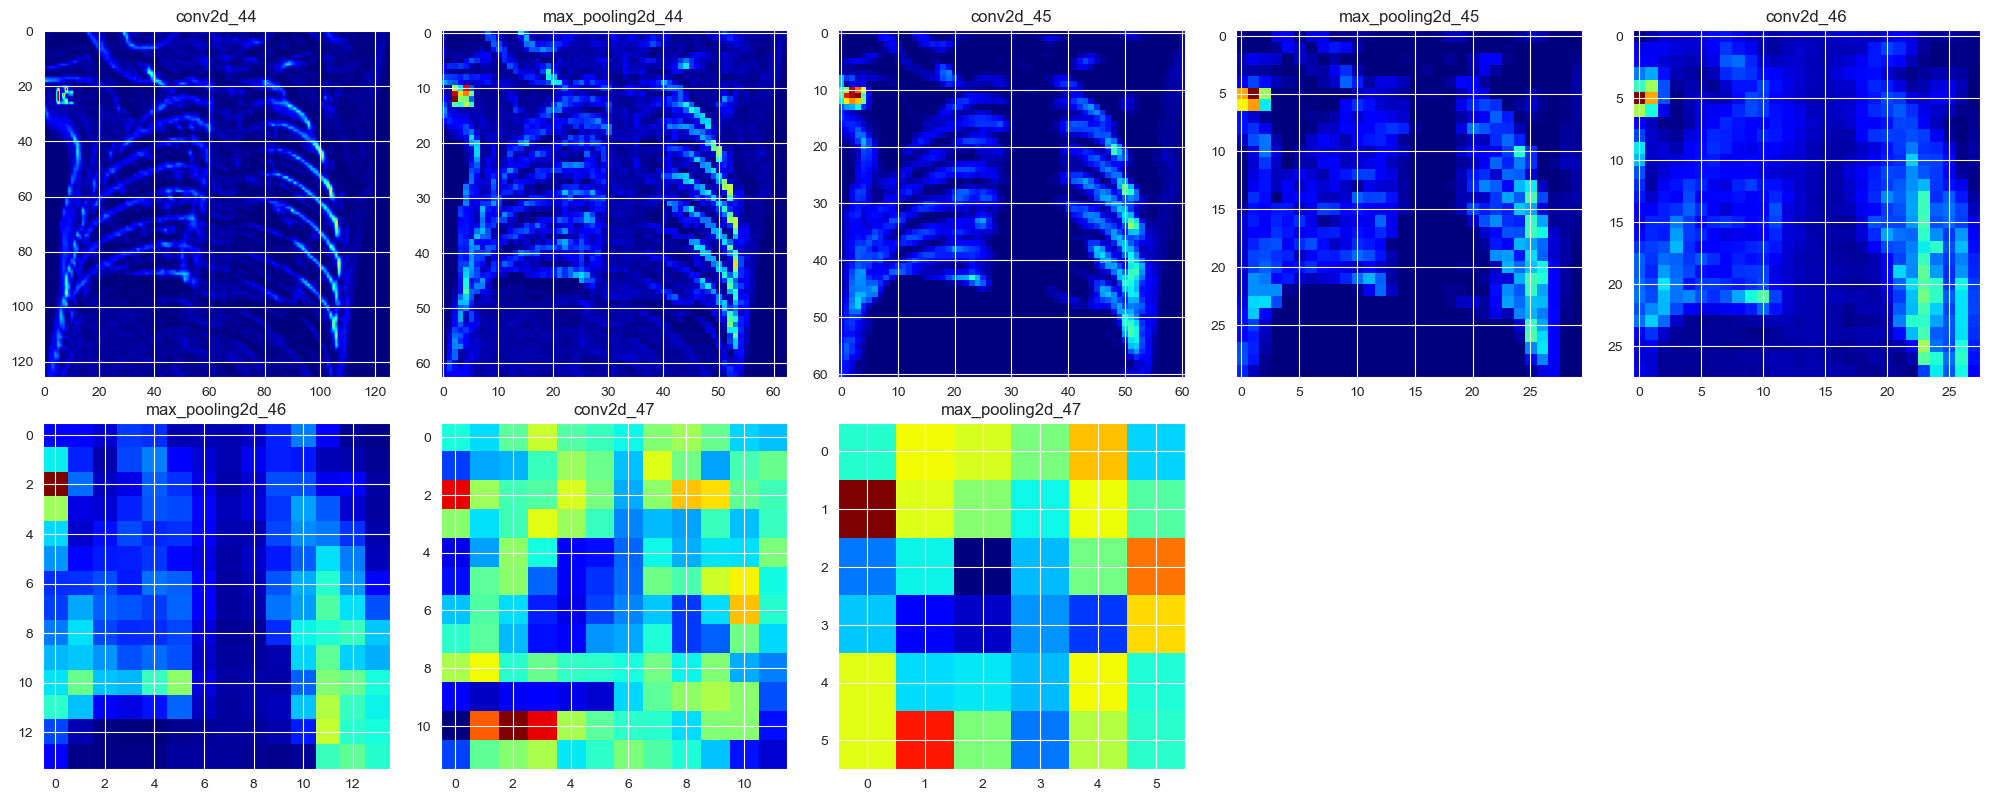

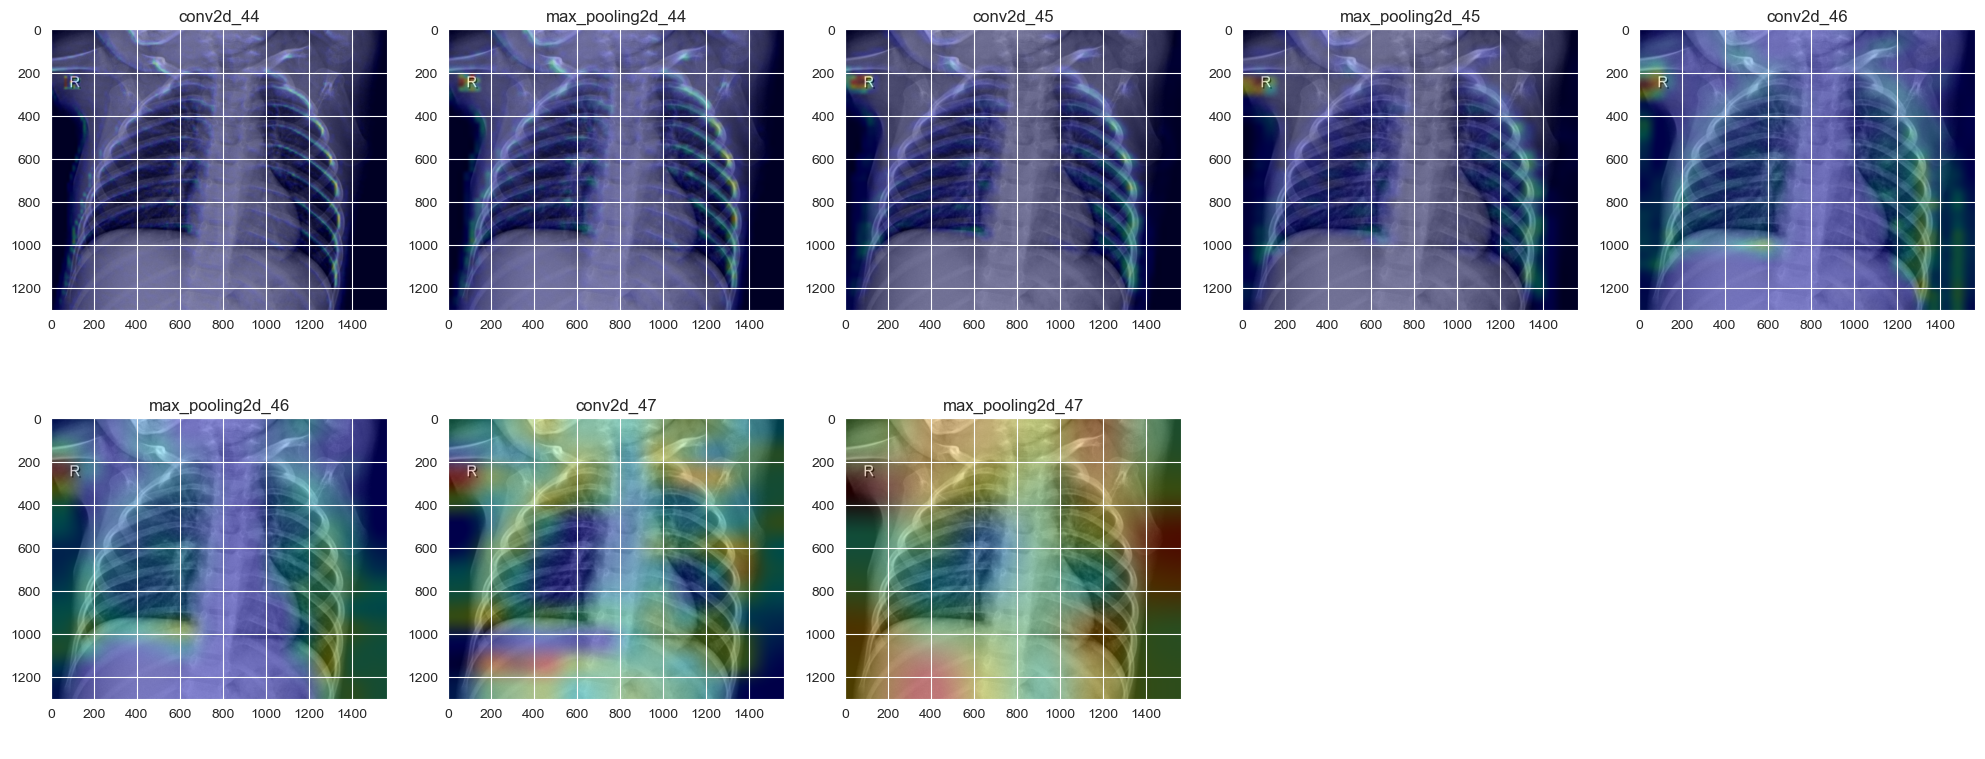

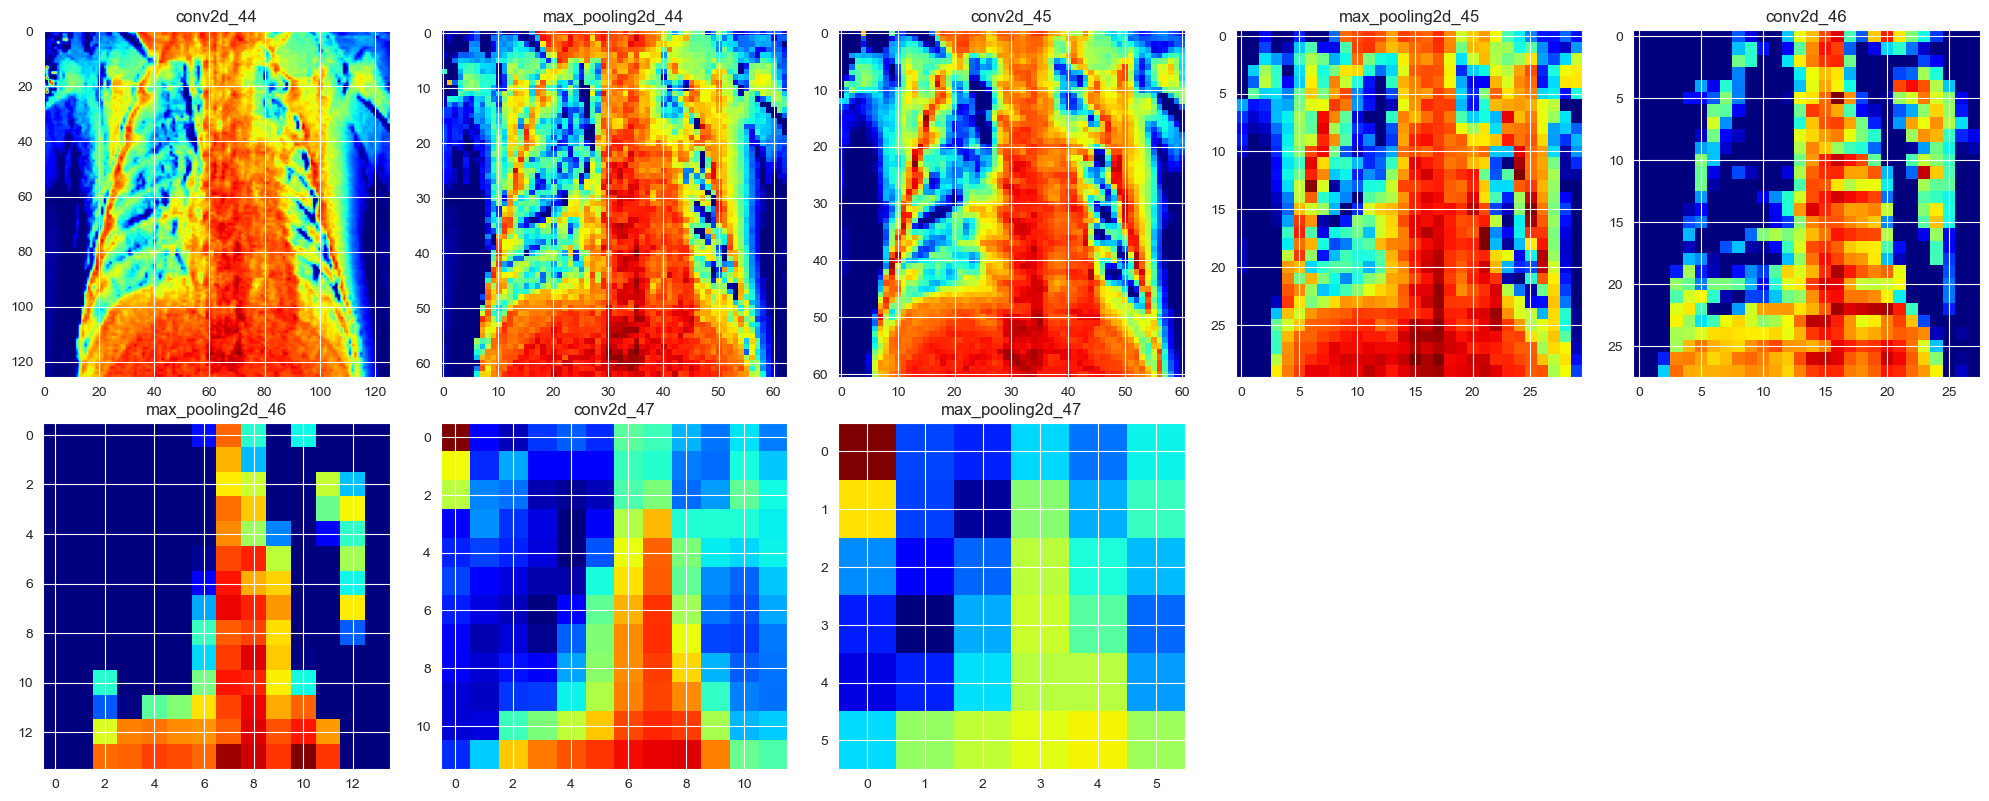

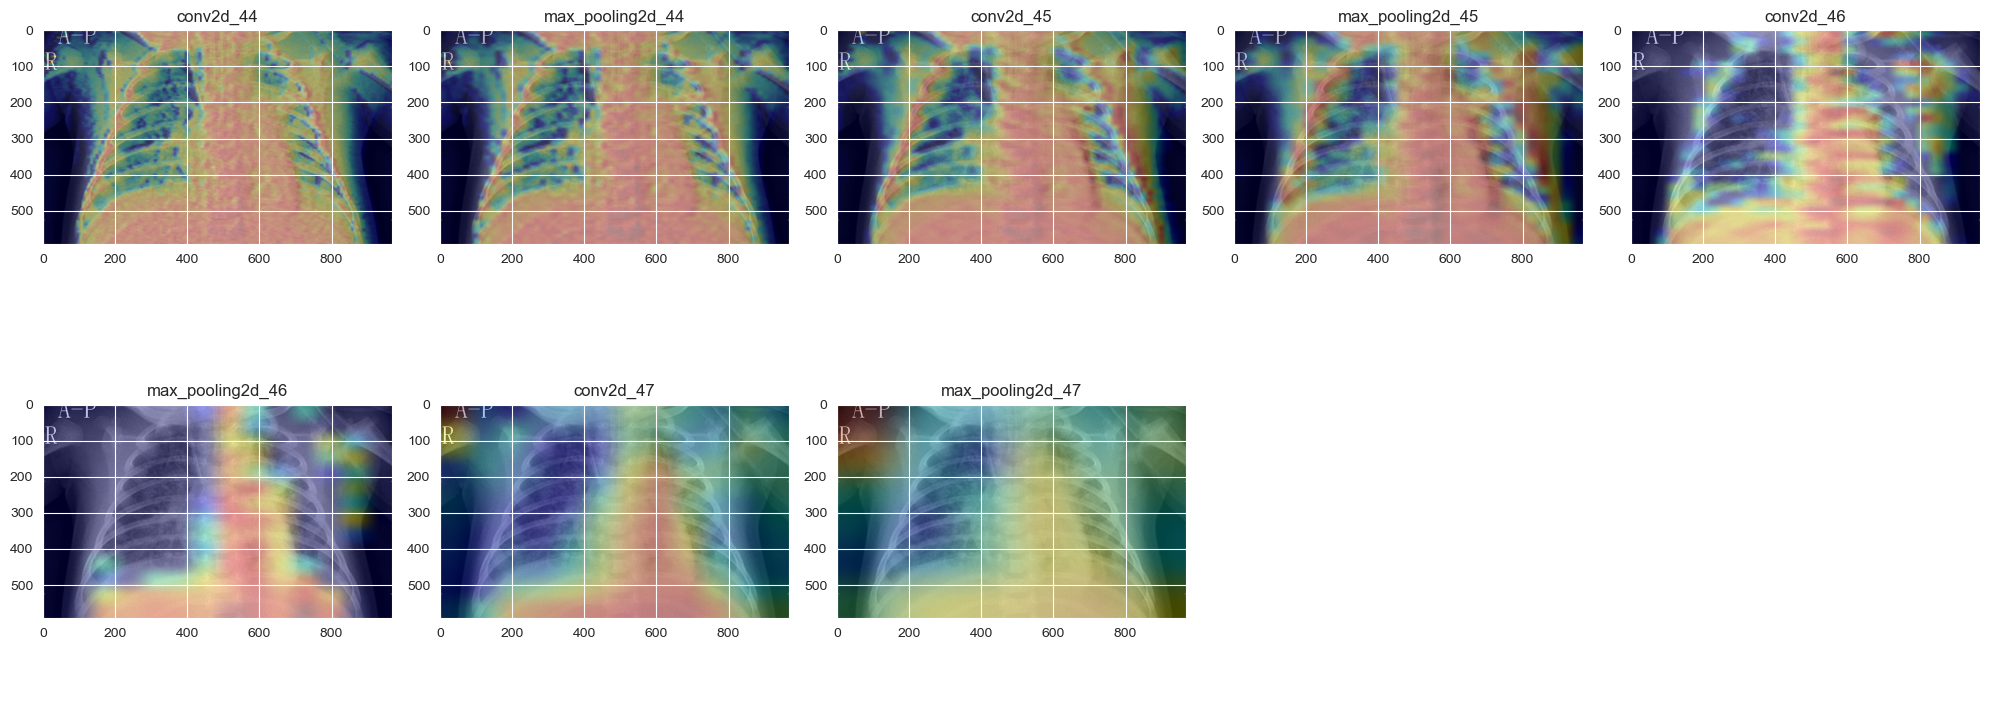

In [31]:
# from cam import make_gradcam_heatmap, display_heatmaps
from common.cam import make_gradcam_heatmap, display_heatmaps
for image in images:
    heatmaps = []
    for layer in model.layers[:model.layers.index(model.get_layer(last_conv_layer_name)) + 1]:
        heatmap = make_gradcam_heatmap(image["array"], model, layer.name)
        heatmaps.append({
            "layer_name": layer.name,
            "image": heatmap
        })

    # Display heatmaps from all layers until the last max pooling layer
    display_heatmaps(image["path"], heatmaps)

    # Display the chosen image superimposed with heatmaps of each layer until the last max pooling layer
    display_heatmaps(image["path"], heatmaps, True)

In [32]:
# Predict
for image in images:
    pred = model.predict(image["array"].reshape(1, img_width, img_height, 1))
    print(pred)
    # Display predicted class
    print("Predicted class: {}".format(subfolders[int(pred[0][0])]))

1/1 [==============================] - 0s 439ms/step
[[0.]]
Predicted class: NORMAL
1/1 [==============================] - 0s 16ms/step
[[1.]]
Predicted class: PNEUMONIA
